## This notebook explores naive methods for classification

In [104]:
%load_ext autoreload
%autoreload 2 
%matplotlib inline

# Set path to find modelling tools for later use
import os
import sys
sys.path.append(os.path.join(os.getcwd(),".."))

from pathlib import Path
from haberrspd.__init_paths import data_root
from haberrspd.preprocess import sentence_level_pause_correction, remap_English_MJFF_participant_ids
import pandas as pd
import numpy as np


# Plot stuff
import seaborn as sns
from scipy.constants import golden
import matplotlib.pyplot as plt
plt.style.use('dark_background')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
# Load data
df = pd.read_csv(data_root / 'EnglishData.csv')
df_meta = pd.read_csv(data_root / 'EnglishParticipantKey.csv',
                      index_col=0,
                      header=0,
                      names=['participant_id','test1','test2', 'diagnosis'])
df_meta.drop(columns=['test1','test2'],inplace=True)

## Create dataset

In [49]:
# Drop too short sentences
char_count_response_threshold=40
df = df[df.groupby(['participant_id', 'sentence_id']).key.transform('count') > char_count_response_threshold]

# Corrected compression times (i.e. timestamp difference / delta)
corrected_compression_times = sentence_level_pause_correction(df)

## Extract summary stats

In [81]:
data = []
for sent_idx in corrected_compression_times.keys():
    for participant in corrected_compression_times[sent_idx]:
        tmp = corrected_compression_times[sent_idx][participant][1:]
        # Append to list which we'll pass to a dataframe in subsequent cells
        data.append((participant, sent_idx, 
                    int(df_meta.loc[participant]),
                    tmp.mean(), tmp.var()))
col_names =  ['Patient_ID', 'Sentence_ID', 'Diagnosis', 'Mean_IKI', 'Var_IKI']
df_summary_stats  = remap_English_MJFF_participant_ids(pd.DataFrame(data, columns = col_names))

In [85]:
df_summary_stats.head()

,Patient_ID,Sentence_ID,Diagnosis,Mean_IKI,Var_IKI
0,10,55,0,180.018290,25674.455362
1,10,55,0,170.727941,25817.206917
2,11,55,0,272.838028,68851.484217
3,11,55,0,236.960000,35109.917852
4,12,55,0,427.287315,117193.241209


In [109]:
df_summary_stats.dropna(inplace=True)
df_summary_stats.isnull().values.any()

False

## Baseline classification

In [155]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC


X = df_summary_stats.iloc[:,[3]].to_numpy()
y = df_summary_stats.Diagnosis.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [160]:
clf = SVC(class_weight='balanced',gamma='auto', probability=True)
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [161]:
y_probas = clf.predict_proba(X_test)

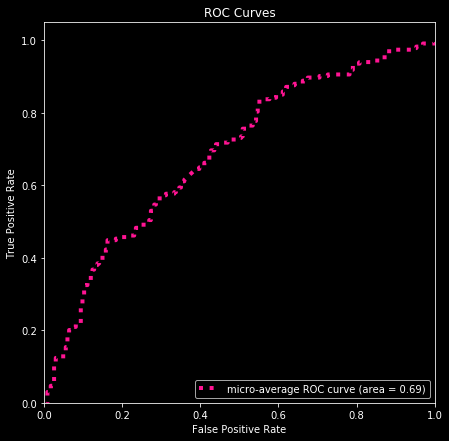

In [171]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_roc_curve(y_test, y_probas,curves='micro',figsize=(7,7))
plt.show()